# Training the keypoint detector

## Solution description

I decided to tackle the problem of keypoints detection on a football pitch as a regression problem. 
Every keypoint is represented by three values: $x, y, v$, where $x$ and $y$ are the coordinates of the point and $v$ indicates if the point is actually visible on the given picture or not. Thus for each image my model outputs a tensor of shape `[n_of_keypoints, 3]`. The coordinates are normalized to be between 0 and 1. The visibility $v$ is also betweeen 0 and 1.

The model is trained with a transfer learning technique. I used a pretrained efficient net b1 as a backbone, with weights frozen during the entire trainig. The backbone is folled with a few convolutional layer (there is no dense layer).

### Loss function

The model faces a challenge of not only predicting the position of a keypoint on the picture but also of predicting if the point is visible at all.
What's more, for every picture there is statistically less keypoints visible than those which are not visible.

I was adviced to use a teacher forcing technique, which means in this case that the model is not punished for incorrectly predicting coordinates of points which are not present at a given picture. It is important because due to my choice of the model's architecture it always *has to predict some $x$ and $y$ values* - one just shouldn't pay attention to them if they are not visible.

I define the loss to be:

\begin{equation}
L = \lambda \cdot PositionLoss + (1 - \lambda) \cdot CrossentropyLoss,
\end{equation}

where $PositionLoss$ is a MSE loss calculated for the visible keypoints and $CrossentropyLoss$ is a cross entropy loss of predicting if a keypoint is visible. $\lambda$ is a parameter weighting the importance of the two losses. 
I found $\lambda = 0.95$ to give good results.

### Data augmentation

For the data augmentation I used geometric transformation: random rotation, random scale and random translation. I wrote this augmentation functions by my own. I decided not to use any other type of augmentation, e.g. changing color, contrast etc. I think that the dataset  is quite varied in terms of colors, some frames are darker, some are lighter, the grass has different colors etc.

### Metrics

As I suggested in my DataExploration notebook, to measure how well the model is dealing with insvisible keypoints I measured precision and recall of predicting that a keypoint is visible. Additionally, after each epoch I logged a graph into a Tensorboard, showing a confusion matrix calculated on a validation dataset.

I also logged predictions showed on a few first validation images, to visually monitor if the model is improving.

## Ideas for further improvement

1. I tried training a detector on images which were passed through a line detector, resulting in grayscale images. I thought it might much easier for the model, but surprisingly I didn't notice any improvement. But I didn't put much time into this idea, so maybe after some parameters tweaks it would be actually better.

2. I could detect lines and try to use them to transform te image so that the image would be laid on a flat map and train a keypoint detector on such a map. 

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime
from functools import partial
import os
from pathlib import Path

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from matplotlib import image
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from pitch_geo import augmentation
from pitch_geo.dataset import keypoints_dataset, tf_dataloaders
from pitch_geo.models import models
from pitch_geo.models.callbacks import LogConfusionMatrixCallback, LogPredictedImages
from pitch_geo.models.loss import create_teacher_forced_loss
from pitch_geo.models.metrics import VisiblePrecision, VisibleRecall
import pitch_geo.vis_utils as vis_utils

# Define hyperparameters

In [2]:
IMG_SIZE = 240
BATCH_SIZE = 32
EPOCHS = 2
TEACHER_FORCING_WEIGHT = 0.95
INITIAL_LEARNING_RATE = 1e-3

# Read the data frame

# Prepare the data loaders

## Read the data frame

In [3]:
train_dataset = keypoints_dataset.get_data(dataset='train')

### Train / validation split

Split the train data into proportion: 85% train set and 15% validation set

In [4]:
train_df, val_df = train_dataset.split(test_size=0.15)

### Create the data loaders

In [5]:
train_data_builder = tf_dataloaders.DatasetBuilder(
    data_frame=train_df, 
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augmentation=augmentation.Sequential(
        [
            augmentation.RandomRotation(angle=10, scale=(0.5, 0.8), p=.5),
            augmentation.RandomTranslation(limit=0.3, p=.5)
        ]
    )
)
train_ds = train_data_builder.build()

val_data_builder = tf_dataloaders.DatasetBuilder(
    data_frame=val_df, 
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
val_ds = val_data_builder.build()

Visualize data from the data loader to see it everything works fine

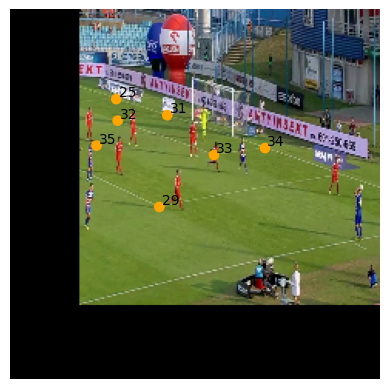

In [6]:
sample_batch = next(iter(train_ds))
        
_ = vis_utils.show_image_with_annotations(
    img = sample_batch[0].numpy()[0,:] / 255., 
    keypoints = sample_batch[1].numpy()[0,:], 
    labels = train_dataset.label_map,
    dot_radius=3, 
    vis=True
)

In [7]:
print(f"Total batches in training set: {len(train_ds)}")
print(f"Total batches in validation set: {len(val_ds)}")

Total batches in training set: 101
Total batches in validation set: 18


# The model

## Get the model

The model is built with the `get_model` function. 

In [8]:
model = models.get_model(img_size=IMG_SIZE, num_keypoints=train_dataset.num_keypoints, dropout=0.1)

In [9]:
model.summary()

Model: "keypoint_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 8, 8, 1280)       6575239   
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 512)         5898752   
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout (Dropout)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 1, 102)   

## Define callbacks

Callbacks used during the training loop.

In [ ]:
model_base_path = Path('checkpoints')
checkpoint_template_name = 'cp.ckpt'
training_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = model_base_path / training_timestamp / checkpoint_template_name
log_dir = Path('logs') / training_timestamp

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch",
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    write_graph=False
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_delta=0.0001,
    min_lr=0.000001,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    min_delta=0.00001,
    verbose=1,
)

log_cm = LogConfusionMatrixCallback(model, log_dir, val_ds)
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_cm)

log_predicted_images = LogPredictedImages(model, log_dir, val_ds, labels=train_dataset.label_map)
log_images_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_predicted_images, grid_size=4)

## Train the model

In [ ]:
%matplotlib

model.compile(
    loss=create_teacher_forced_loss(weight=TEACHER_FORCING_WEIGHT),
    optimizer=tf.keras.optimizers.Adam(INITIAL_LEARNING_RATE),
    metrics=[
        VisiblePrecision(),
        VisibleRecall(),
    ],
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks = [
        model_checkpoint_callback,
        tensorboard_callback,
        reduce_lr,
        early_stopping,
        cm_callback,
        log_images_callback
    ],
)

Using matplotlib backend: <object object at 0x7f7da81ab970>
Epoch 1/2
101/101 [==============================] - 98s 808ms/step - loss: 0.0198 - visible_precision: 0.8058 - visible_recall: 0.5970 - val_loss: 0.0083 - val_visible_precision: 0.9485 - val_visible_recall: 0.8770 - lr: 0.0010
Epoch 2/2
101/101 [==============================] - 24s 239ms/step - loss: 0.0102 - visible_precision: 0.8900 - visible_recall: 0.8599 - val_loss: 0.0063 - val_visible_precision: 0.9610 - val_visible_recall: 0.8973 - lr: 0.0010


## Tensorboard

In [ ]:
# Uncomment those lines to use Tensorboard inside the notebook

# %load_ext tensorboard
# %tensorboard --logdir logs

## Reread the best model and save it to SavedModel

In [ ]:
model = models.get_model(img_size=IMG_SIZE, num_keypoints=train_dataset.num_keypoints, dropout=0.1)
model.load_weights(model_path)
model.save(model_path.parent / 'saved_model')

INFO:tensorflow:Assets written to: checkpoints/20230108_124710/saved_model/assets


INFO:tensorflow:Assets written to: checkpoints/20230108_124710/saved_model/assets
